In [1]:
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

## load data

ex0.txt, ex1.txt :
- each row represent a instance and can be split by '\t'  
- the last column is the class label  
- the first column is constant

In [2]:
def loadDataSet(filename):
    instList = []
    labelList = []
    fr = open(filename)
    for line in fr.readlines():
        lineList = line.split('\t')
        instance = [float(x) for x in lineList[:-1]]
        instList.append(instance)
        label = float(lineList[-1])
        labelList.append(label)
    
    return np.array(instList), np.array(labelList)

In [3]:
DATA_ROOT = "data/regression/"

(200, 2)
(200,)
[[ 1.        0.067732]
 [ 1.        0.42781 ]]
[ 3.176513  3.816464]


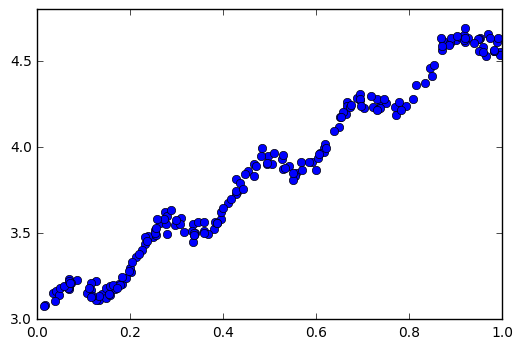

In [4]:
xArr, yArr = loadDataSet(DATA_ROOT + 'ex0.txt')
print(xArr.shape)
print(yArr.shape)
print(xArr[:2,:])
print(yArr[:2])
plt.figure()
plt.plot(xArr[:,1], yArr, 'o')

## standar linear regression  

In [5]:
def standRegres(xArr, yArr):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    print(xMat.shape)
    print(yMat.shape)
    assert xMat.shape[0] == yMat.shape[0], 'the shape of x and y not consistent'
    # matrix calculation
    xTx = xMat.T * xMat
    if np.linalg.det(xTx) == 0.0:
        print ("This matrix is singular, cannot do inverse!!")
        return
    wHatMat = xTx.I * (xMat.T * yMat)
    return wHatMat

In [6]:
wHatMat = standRegres(xArr, yArr)
print(wHatMat.shape)
print(wHatMat)

(200, 2)
(200, 1)
(2, 1)
[[ 3.00774324]
 [ 1.69532264]]


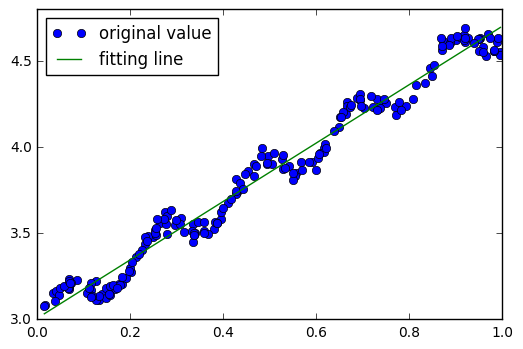

In [7]:
# prevent the disorder value
xCopyArr = xArr.copy()
xCopyArr.sort(0)
yHatMat = np.mat(xCopyArr) * wHatMat
# plot
plt.figure()
plt.plot(xArr[:,1], yArr, 'o', label="original value")
plt.plot(xCopyArr[:,1], yHatMat, label = "fitting line")
plt.legend(loc='best')

In [8]:
## evaluation, compute the correlation coefficient  
yHatMat = np.mat(xArr) * wHatMat
np.corrcoef(yHatMat.T, yArr) # insure two element are row vector

array([[ 1.        ,  0.98647356],
       [ 0.98647356,  1.        ]])

## Local Weighted Linear Regression (LWLR)

In [9]:
def kernel(testPoint, xArr, K = 1.0):
    xMat = np.mat(xArr)
    m = len(xMat)
    wMat = np.mat(np.eye(m))
    for i in range(m):
        diffMat = testPoint - xMat[i,:]
        wMat[i,i] = np.exp((diffMat * diffMat.T) / (-2.0*K**2))
    return wMat

def localWeightedLR(testPoint, xArr, yArr, K = 1.0):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    wMat = kernel(testPoint, xArr, K)
    xTx = xMat.T * (wMat * xMat)
    if np.linalg.det(xTx) == 0.0:
        print ("This matrix is singular, cannot do inverse !!")
        return
    wHatMat = xTx.I * (xMat.T * (wMat * yMat))
    return testPoint*wHatMat

def localWeightedLRTest(testArr, xArr, yArr, K = 1.0):
    m = np.shape(testArr)[0]
    yHat = np.zeros(m)
    for i in range(m):
         yHat[i] = localWeightedLR(testArr[i], xArr, yArr, K)
    return yHat

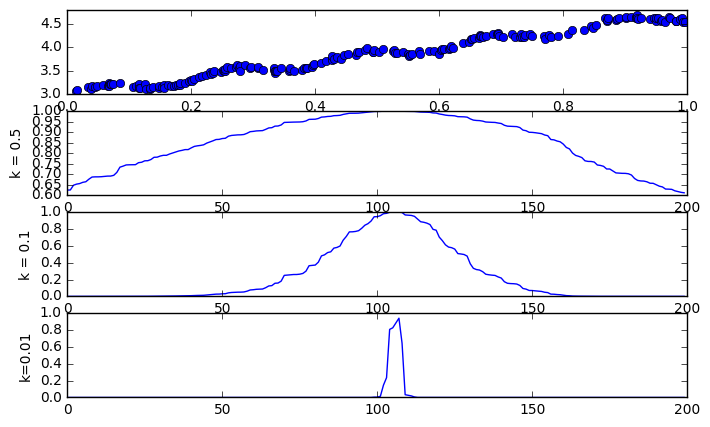

In [10]:
## the impact of parameter k

xArr, yArr = loadDataSet(DATA_ROOT + 'ex0.txt')

sortedIndex = xArr[:,1].argsort()
xSorted = xArr[sortedIndex,:]

testPoint = [1,0.5]

plt.figure(figsize=(8,5))

ax = plt.subplot(411)
ax.plot(xSorted[:,1], yArr[sortedIndex], 'o')

ax = plt.subplot(412)
testWMat = kernel(testPoint, xSorted, 0.5)
ax.plot(np.diagonal(testWMat))
ax.set_ylabel('k = 0.5')

ax = plt.subplot(413)
testWMat = kernel(testPoint, xSorted, 0.1)
ax.plot(np.diagonal(testWMat))
ax.set_ylabel('k = 0.1')

ax = plt.subplot(414)
testWMat = kernel(testPoint, xSorted, 0.01)
ax.plot(np.diagonal(testWMat))
ax.set_ylabel('k=0.01')


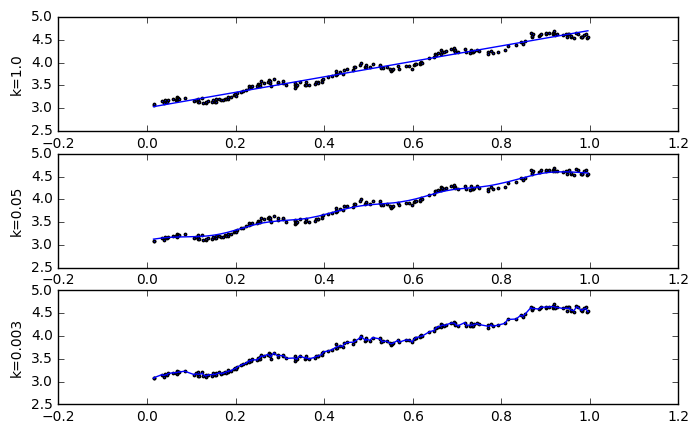

In [11]:
xArr, yArr = loadDataSet(DATA_ROOT + 'ex0.txt')

sortedInds = xArr[:,1].argsort()
xSorted = xArr[sortedInds,:]
ySorted = yArr[sortedInds]

fig = plt.figure(figsize=(8,5))

# k = 1.0
yHat1 = localWeightedLRTest(xArr, xArr, yArr, 1.0)
ax = fig.add_subplot(311)
ax.scatter(xSorted[:,1], ySorted, s=3)
ax.plot(xSorted[:,1], yHat1[sortedInds])
ax.set_ylabel('k=1.0')

# k = 0.05
yHat1 = localWeightedLRTest(xArr, xArr, yArr, 0.05)
ax = fig.add_subplot(312)
ax.scatter(xSorted[:,1], ySorted, s=3)
ax.plot(xSorted[:,1], yHat1[sortedInds])
ax.set_ylabel('k=0.05')

# k = 0.08
yHat1 = localWeightedLRTest(xArr, xArr, yArr, 0.003)
ax = fig.add_subplot(313)
ax.scatter(xSorted[:,1], ySorted, s=3)
ax.plot(xSorted[:,1], yHat1[sortedInds])
ax.set_ylabel('k=0.003')

## Cross Validaation

### function realizaiton

In [37]:
def crossValidation(xArr, yArr, kFolder, classifyFunc, *args):
    m, n = xArr.shape
    indexList = range(m)
    np.random.shuffle(indexList)
    
    # split into k subset
    subSetSize = m / kFolder
    subSetDic = {}
    for i in range(kFolder):
        subSetDic[i] = indexList[i*subSetSize:(i+1)*subSetSize]
    
    # leave one cross validation
    errList = []
    for i in range(kFolder):
        testIndexList = subSetDic[i]
        trainIndexList = []
        for j in range(kFolder):
            if j == i:
                continue
            trainIndexList.extend(subSetDic[j])
        
        testXArr = xArr[testIndexList]
        trainXArr = xArr[trainIndexList]
        testYArr = yArr[testIndexList]
        trainYArr = yArr[trainIndexList]
        
        yHat = classifyFunc(testXArr, trainXArr, trainYArr, *args)
        err = ressError(testYArr, yHat)
        
        errList.append(err)
    
    return errList

In [38]:
def crossValidationRandom(xArr, yArr, kFolder, classifyFunc, *args):
    m, n = xArr.shape
    indexList = range(m)
    
    errList = []
    for i in range(kFolder):
        np.random.shuffle(indexList)
        trainXList = []; trainYList = []
        testXList = []; testYList = []
        for j in range(m):
            if j < 0.9*m:
                trainXList.append(xArr[indexList[j]])
                trainYList.append(yArr[indexList[j]])
            else:
                testXList.append(xArr[indexList[j]])
                testYList.append(yArr[indexList[j]])
        
        yHat = classifyFunc(np.array(trainXList), np.array(trainXList), np.array(trainYList), *args)
        err = ressError(np.array(trainYList), yHat)
        
        errList.append(err)
    
    return errList

### Test

In [17]:
xArr, yArr = loadDataSet(DATA_ROOT + 'ex0.txt')
errDiffKDic = {}
kList = [0.01, 0.05, 0.1, 0.3, 0.35,0.5, 0.7 , 0.9, 1.0]
for k in kList:
    errList = crossValidation(xArr, yArr, 10, localWeightedLRTest, (k))
    errDiffKDic[k] = errList
    print(np.mean(errList))
    print(errList)

0.153172650389
[0.20003953536071517, 0.17026547916743756, 0.12803891035548301, 0.13055613793916318, 0.1950849187069468, 0.13113825991708702, 0.15333828623926238, 0.15305034508851686, 0.12272150818798895, 0.14749312292975233]
0.255232134564
[0.24412203642430072, 0.2793910166476718, 0.26743712190607638, 0.25290819844165285, 0.29222642220687495, 0.23965463993605232, 0.25972528552395363, 0.21972141558851102, 0.22918698245954666, 0.26794822650619676]
0.347741510383
[0.35977967733137728, 0.41152136140146428, 0.38785708354011211, 0.31312940594821642, 0.35136636807472615, 0.31989930853010745, 0.35147738732910216, 0.33482150706258257, 0.32754630649817945, 0.32001669811131667]
0.369862734206
[0.34088899397036826, 0.43473431751393132, 0.34976817123999449, 0.37011762470373216, 0.3614022456351027, 0.34383049553129141, 0.35206797867007505, 0.35562007255956435, 0.38583049593199231, 0.40436694630786663]
0.366224121833
[0.33434018195917398, 0.37903630585588971, 0.35400128961434291, 0.36194969853894376,

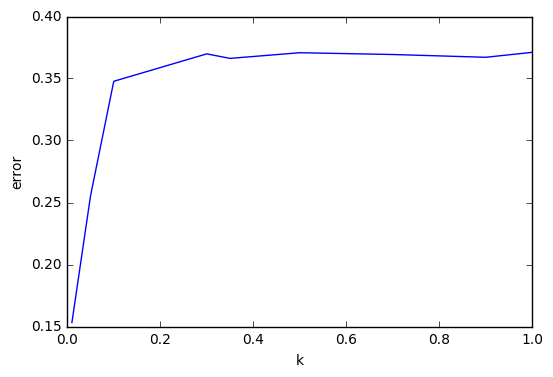

In [22]:
errMeans = [ np.mean(errDiffKDic[k]) for k in kList]
plt.plot(kList, errMeans)
plt.xlabel("k")
plt.ylabel("error")

In [34]:
xArr, yArr = loadDataSet(DATA_ROOT + 'ex0.txt')
errDiffKDic = {}
kList = [0.01, 0.05, 0.1, 0.3, 0.35,0.5, 0.7 , 0.9, 1.0]
for k in kList:
    errList = crossValidationRandom(xArr, yArr, 10, localWeightedLRTest, (k))
    errDiffKDic[k] = errList
    print(np.mean(errList))
    print(errList)

0.359365248968
[0.35484727790451792, 0.35377019945178972, 0.36301705032980597, 0.3617536863757696, 0.36322052103060842, 0.35314204000332461, 0.37372774913131496, 0.35869979075374042, 0.35231707689844288, 0.35915709780396743]
0.734245049971
[0.73232038583700698, 0.73032975077558471, 0.74033759128381516, 0.72668272150045887, 0.74871836623876764, 0.7383732332487436, 0.72942999343950177, 0.73196852745981844, 0.72823658323843032, 0.7360533466871384]
1.02986097204
[1.0381503594627439, 1.0378942090684109, 1.043875299863221, 1.0406562432305746, 1.0235712958158003, 1.0279179378420256, 1.0167285702320656, 1.0131520809423389, 1.0176956077503854, 1.0389681161998092]
1.10137316972
[1.1114687502989966, 1.0852225420588462, 1.1097149748379147, 1.1127140820970338, 1.0958318164226188, 1.116577640965271, 1.1122329925858452, 1.0819183220458362, 1.0989520965939863, 1.0890984792747189]
1.1013208689
[1.1037680525768681, 1.0994259003094757, 1.117074796265747, 1.1121621084996796, 1.0795212014873581, 1.09858146

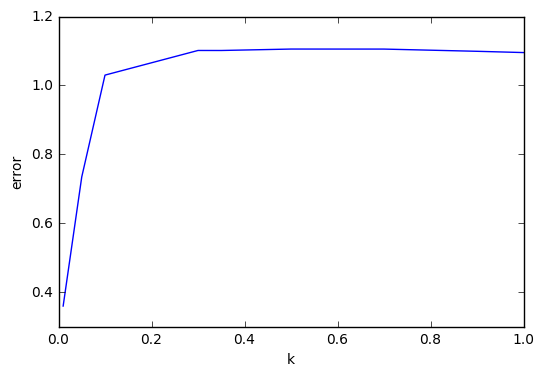

In [35]:
errMeans = [ np.mean(errDiffKDic[k]) for k in kList]
plt.plot(kList, errMeans)
plt.xlabel("k")
plt.ylabel("error")

## A real case

In [12]:
def ressError(yArr, yHatArr):
    return np.sqrt(np.sum((yArr - yHatArr)**2))

In [13]:
abXArr, abYArr = loadDataSet(DATA_ROOT + 'abalone.txt')
print(abXArr.shape)
print(abYArr.shape)
print(abXArr[:5,:])
print(abYArr[:5])

(4177, 8)
(4177,)
[[ 1.      0.455   0.365   0.095   0.514   0.2245  0.101   0.15  ]
 [ 1.      0.35    0.265   0.09    0.2255  0.0995  0.0485  0.07  ]
 [-1.      0.53    0.42    0.135   0.677   0.2565  0.1415  0.21  ]
 [ 1.      0.44    0.365   0.125   0.516   0.2155  0.114   0.155 ]
 [ 0.      0.33    0.255   0.08    0.205   0.0895  0.0395  0.055 ]]
[ 15.   7.   9.  10.   7.]


In [15]:
yHat = localWeightedLRTest(abXArr, abXArr, abYArr, 0.5)
error = ressError(abYArr, yHat)
print(error)

137.213029174


In [54]:
k = 0.5
errList = crossValidation(abXArr, abYArr, 10, localWeightedLRTest, (k))
print(np.mean(errList))
print(errList)

44.9445748143
[45.085810465692347, 51.467581260551185, 43.871279531623813, 42.789597235313302, 44.088798944085717, 47.021187189685001, 44.988391255648445, 43.981746583346776, 44.243809667012101, 41.907546009569316]


In [17]:
errDiffKDic = {}
for k in [0.05, 0.1, 0.3, 0.5, 0.9, 1.0]:
    errList = crossValidation(abXArr, abYArr, 10, localWeightedLRTest, (k))
    errDiffKDic[k] = errList
    print(np.mean(errList))
    print(errList)

This matrix is singular, cannot do inverse !!
nan
[51.901729968825691, 63.441088885012988, 107.96588802971033, 72.219558633866384, 70.897360539900248, 44.645420484041239, nan, 100.48327196852497, 52.029392530515267, 54.099617350079633]
44.8522534962
[49.055883886095728, 47.638667612752769, 43.979854426429775, 42.019098534934272, 43.905861097914546, 41.959938324319936, 43.961383054088493, 45.288095861321153, 44.585272911733732, 46.128479252674602]
43.6150531098
[39.978495827941366, 43.557789126993427, 40.445118721695856, 44.502985822371855, 43.231082304281173, 45.059067670269904, 46.584369126843605, 46.721359955817412, 43.816482993402914, 42.253779548786419]
44.8277936518
[42.255068511580987, 42.413851985813416, 47.805553021676033, 46.357538662231711, 45.487321514907556, 41.354507515949081, 44.894826946209079, 51.005069060119034, 43.971818940516442, 42.732380359042175]
45.7285726689
[47.376882428486546, 55.207861001169746, 45.402357639594641, 43.301757139147668, 40.857657359279393, 41.1

## Ridge Regression - Shrinkage coefficient

In [14]:
def ridgeRegress(xMat, yMat, lam = 0.2):
    xMat = np.mat(xMat) # m * n
    yMat = np.mat(yMat)
    xTx = xMat.T * xMat # n*m * m*n = n*n
    denom =  xTx + lam * np.eye(xTx.shape[0])
    if np.linalg.det(denom) == 0.0: 
        # if lam == 0, this condition will be true
        print("This matrix is singular, cannot do inverse")
        return
    wMat = denom.I * (xMat.T * yMat)
    return wMat

def ridgeTest(xArr, yArr, numTestPts = 30):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    
    # standardization
    xMean = np.mean(xMat, 0)
    xVar = np.var(xMat, 0)
    xMat = (xMat - xMean) / xVar
    
    yMean = np.mean(yMat, 0)
    yMat = yMat - yMean
    
    wMats = np.zeros((numTestPts, xMat.shape[1]))
    for i in range(numTestPts):
        wMat = ridgeRegress(xMat, yMat, np.exp(i-10))
        wMats[i, :] = wMat.T
    
    return wMats

In [15]:
abXArr, abYArr = loadDataSet(DATA_ROOT + 'abalone.txt')
print(abXArr.shape)
print(abYArr.shape)
print(abXArr[:5,:])
print(abYArr[:5])

(4177, 8)
(4177,)
[[ 1.      0.455   0.365   0.095   0.514   0.2245  0.101   0.15  ]
 [ 1.      0.35    0.265   0.09    0.2255  0.0995  0.0485  0.07  ]
 [-1.      0.53    0.42    0.135   0.677   0.2565  0.1415  0.21  ]
 [ 1.      0.44    0.365   0.125   0.516   0.2155  0.114   0.155 ]
 [ 0.      0.33    0.255   0.08    0.205   0.0895  0.0395  0.055 ]]
[ 15.   7.   9.  10.   7.]


(30, 8)


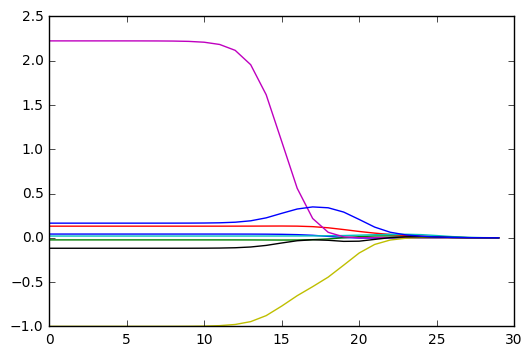

In [34]:
ridgeWeights = ridgeTest(abXArr, abYArr)
print(ridgeWeights.shape)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ridgeWeights)

## Lasso approximate to stage wise

In [16]:
def standardize(xMat):
    inMat = xMat.copy()
    inMatMean = np.mean(inMat, 0)
    inMatVar = np.var(inMat, 0)
    inMat = (inMat - inMatMean) / inMatVar
    
    return inMat

def stageWise(xArr,yArr,eps=0.01,numIt=100):
    xMat = np.mat(xArr); yMat=np.mat(yArr).T
    yMean = np.mean(yMat,0)
    yMat = yMat - yMean     #can also regularize ys but will get smaller coef
    xMat = standardize(xMat)
    m,n=np.shape(xMat)
    returnMat = np.zeros((numIt,n)) #testing code remove
    ws = np.zeros((n,1)); wsTest = ws.copy(); wsMax = ws.copy()
    for i in range(numIt):
        print ws.T
        lowestError = np.inf; 
        for j in range(n):
            for sign in [-1,1]:
                wsTest = ws.copy()
                wsTest[j] += eps*sign
                yTest = xMat*wsTest
                rssE = ressError(yMat.A,yTest.A)
                if rssE < lowestError:
                    lowestError = rssE
                    wsMax = wsTest
        ws = wsMax.copy()
        returnMat[i,:]=ws.T
    return returnMat

In [18]:
abXArr, abYArr = loadDataSet(DATA_ROOT + 'abalone.txt')
print(abXArr.shape)
print(abYArr.shape)
print(abXArr[:5,:])
print(abYArr[:5])

(4177, 8)
(4177,)
[[ 1.      0.455   0.365   0.095   0.514   0.2245  0.101   0.15  ]
 [ 1.      0.35    0.265   0.09    0.2255  0.0995  0.0485  0.07  ]
 [-1.      0.53    0.42    0.135   0.677   0.2565  0.1415  0.21  ]
 [ 1.      0.44    0.365   0.125   0.516   0.2155  0.114   0.155 ]
 [ 0.      0.33    0.255   0.08    0.205   0.0895  0.0395  0.055 ]]
[ 15.   7.   9.  10.   7.]


In [36]:
result = stageWise(abXArr, abYArr, 0.01, 200) 

[[ 0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.    0.    0.    0.01  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.02  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.03  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.04  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.05  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.06  0.    0.    0.    0.  ]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.  ]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.01]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.02]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.03]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.04]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.05]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.06]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.07]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.08]]
[[ 0.    0.    0.01  0.05  0.    0.    0.    0.08]]
[[ 0.    0.    0.01  0.05  0.    0.    0.    0.09]]
[[ 0.    0.    0.01  0.05  0.    0.    0.    0.1 ]]
[[ 0.    0.    0.01  0.05  0

(200, 8)


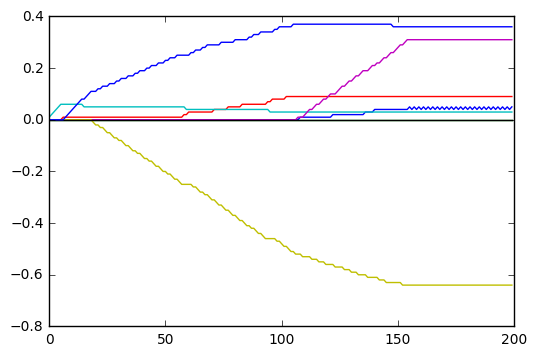

In [37]:
print(result.shape)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(result)